# Exploratory data analysis

In [74]:
import pandas as pd  
import numpy as np
import warnings 
import math
warnings.simplefilter('ignore')
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt

# import custom functions
import sys
sys.path.append("../")
from projectname import custom_funcs

## open data
### 1. NCDB with full feature set

In [85]:
df = pd.read_csv("../data/cleaned/NCDB_cleaned_N924.csv")

In [86]:
print("Number of complete records: {}".format(df.shape[0]))
print("Number of variables: {}".format(df.shape[1]))
df.head()

Number of complete records: 924
Number of variables: 9


,AGE,SEX,tumor_size_bins_cm,tumor_site,immuno_suppressed,tumor_lymphocytes,lymph_vasc_invasion,tumor_depth,metastasis
0,58,1,1.0,extremity,0,0,0.0,3.8,0.0
1,88,1,1.0,other,1,1,0.0,4.2,0.0
2,63,1,1.0,extremity,0,0,0.0,1.0,0.0
3,76,1,1.0,head_neck,0,1,0.0,9.4,1.0
4,65,1,1.0,extremity,0,0,1.0,0.8,1.0


In [87]:
custom_funcs.N_table(df, df['metastasis'])

,metastasis,N
0,0.0,621
1,1.0,303


### 2.  NCDB + SEER, smaller feature set

In [186]:
NCDB2 = pd.read_csv("../data/cleaned/NCDB_cleaned_for_SEER_merge.csv")
SEER = pd.read_csv("../data/cleaned/SEER_cleaned_for_NCDB_merge.csv")
NCDB2.shape


(9109, 5)

In [187]:
SEER.shape

(1803, 5)

In [188]:
# stack rows to merge into single df
df2 = NCDB2.append(SEER)

In [189]:
print("Number of complete records: {}".format(df2.shape[0]))
print("Number of variables: {}".format(df2.shape[1]))
df2.head()

Number of complete records: 10912
Number of variables: 5


,AGE,SEX,tumor_size_bins_cm,tumor_site,metastasis
0,71,1,1.0,head_neck,0.0
1,43,1,1.0,other,0.0
2,59,2,1.0,extremity,0.0
3,75,2,1.0,extremity,1.0
4,82,2,1.0,other,0.0


In [90]:
custom_funcs.N_table(df2, df2['metastasis'])

,metastasis,N
0,0.0,7451
1,1.0,3461


## Explore features and outcome

### Location of the tumor

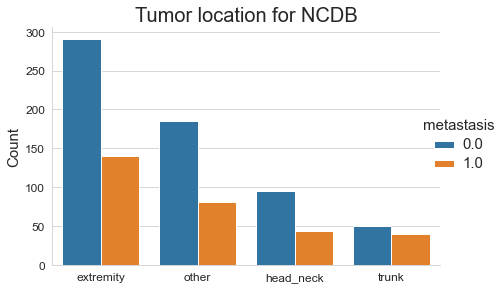

In [175]:
g = sns.catplot(data = df, x ="tumor_site" , kind = "count",
                     hue = "metastasis" , height = 4, aspect = 1.5)
plt.xlabel( "", size =  15)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 15)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.title("Tumor location for NCDB", fontsize = 20)
plt.savefig('../figures/tumor_location.png', bbox_inches = 'tight')

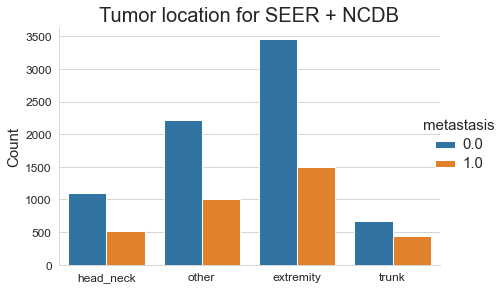

In [176]:
g  = sns.catplot(data = df2,
                     x ="tumor_site" , kind = "count",
                     hue = "metastasis" , height = 4, aspect = 1.5)
plt.xlabel( "", size =  15)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 15)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.title("Tumor location for SEER + NCDB", fontsize = 20)

plt.savefig('../figures/tumor_location.png', bbox_inches = 'tight')


### Tumor size

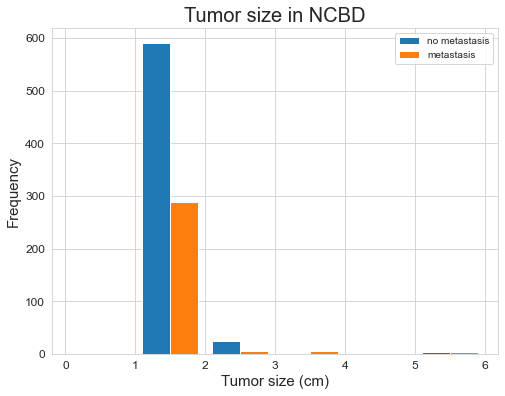

In [177]:
bins = np.linspace(0, 6, 7)
group1 =  df.tumor_size_bins_cm[df.metastasis == 0]
group2 = df.tumor_size_bins_cm[df.metastasis == 1]

plt.figure(figsize = (8, 6))
plt.hist([group1, group2],
        bins, label = ["no metastasis","metastasis"])
plt.legend(loc = 'upper right')
plt.xlabel("Tumor size (cm)", size =  15)
plt.ylabel ("Frequency",  size = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Tumor size in NCBD", size = 20)
plt.show()

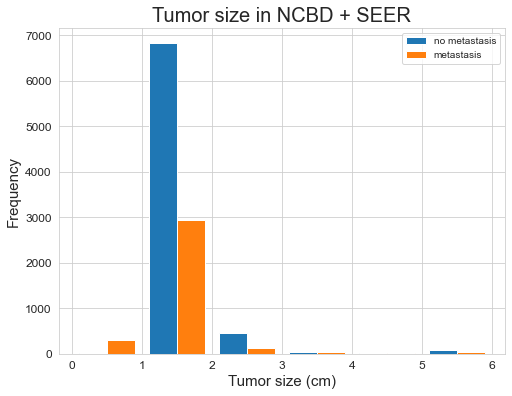

In [167]:
bins = np.linspace(0, 6, 7)
group1 = df2.tumor_size_bins_cm[df2.metastasis == 0]
group2 = df2.tumor_size_bins_cm[df2.metastasis == 1]

plt.figure(figsize = (8, 6))
plt.hist([group1, group2],
        bins, label = ["no metastasis", "metastasis"])
plt.legend(loc = 'upper right')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel("Tumor size (cm)", size =  15)
plt.ylabel ("Frequency",  size = 15)
plt.title("Tumor size in NCBD + SEER", size = 20)
plt.show()

## Demographics
### Age

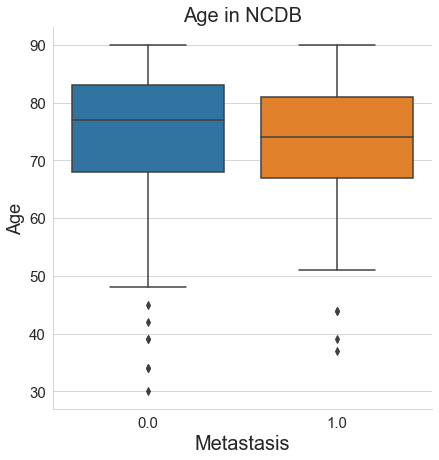

In [183]:
g= sns.catplot(data = df,
                     x = "metastasis", y = "AGE", kind = "box",
                      height = 6)
plt.xlabel("Metastasis", size =  20)
plt.ylabel ("Age",  size = 18)
plt.title("Age in NCDB", size =  20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('../figures/age_and_mets.png', bbox_inches = 'tight')


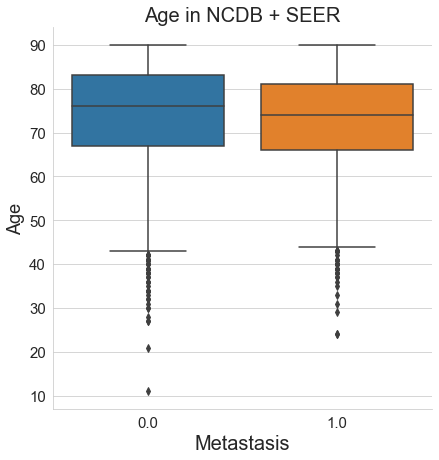

In [97]:
g= sns.catplot(data = df2,
                     x = "metastasis", y = "AGE", kind = "box",
                      height = 6)
plt.xlabel("Metastasis", size =  20)
plt.ylabel ("Age",  size = 18)
plt.title("Age in NCDB + SEER", size =  20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.savefig('../figures/age_and_mets.png', bbox_inches = 'tight')


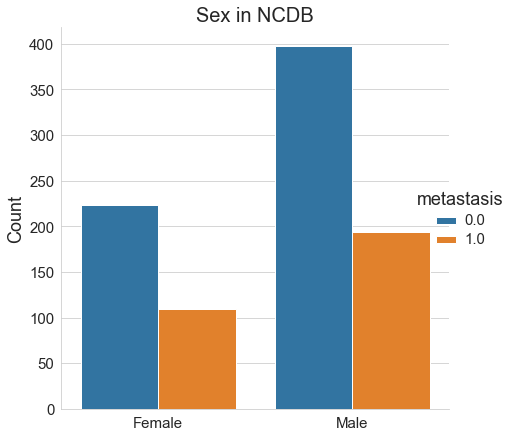

In [102]:
# how to change labels...
df['Sex'] = df.SEX.apply(lambda x: 'Male' if x == 1 else 'Female').astype('category')

g= sns.catplot(data = df,  x = "Sex", kind = "count",
                     hue = "metastasis", height = 6)
plt.xlabel("", size =  20)
plt.ylabel ("Count",  size = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Sex in NCDB", size = 20)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/sex_and_mets.png', bbox_inches = 'tight')

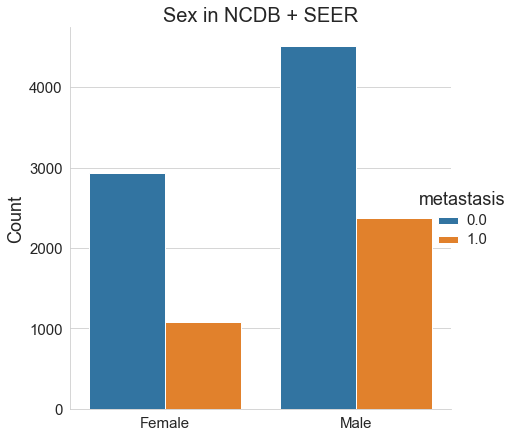

In [101]:
# how to change labels...
df2['Sex'] = df2.SEX.apply(lambda x: 'Male' if x == 1 else 'Female').astype('category')

g= sns.catplot(data = df2,  x = "Sex", kind = "count",
                     hue = "metastasis", height = 6)
plt.xlabel("", size =  20)
plt.ylabel ("Count",  size = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Sex in NCDB + SEER", size = 20)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/sex_and_mets.png', bbox_inches = 'tight')

## Explore NCDB-only features
### Tumor infiltrating lymphocytes 


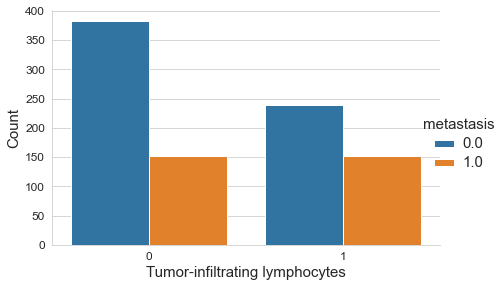

In [180]:
g= sns.catplot(data = df, 
                     x = "tumor_lymphocytes", kind = "count",
                     hue = "metastasis", height = 4, aspect = 1.5 )
plt.xlabel("Tumor-infiltrating lymphocytes", size = 18)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/tumor_lymphocytes.png', bbox_inches = 'tight')


### Lymphnode vascular invasion
Indicates the presence or absence of tumor cells in lymphatic channels (not lymph nodes) or blood vessels within the primary tumor as noted microscopically by the pathologist.

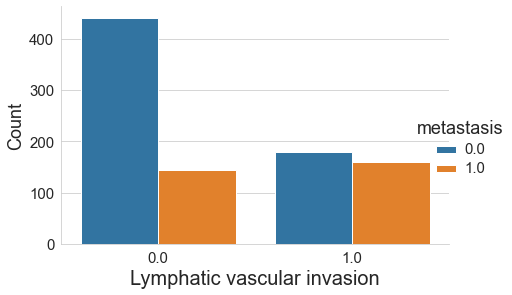

In [179]:

g= sns.catplot(data = df, x = "lymph_vasc_invasion", kind = "count",
                     hue = "metastasis", height = 4, aspect = 1.5)
plt.xlabel("Lymphatic vascular invasion", size =  20)
plt.ylabel ("Count",  size = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 15)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/tumor_lymph_vasc_invasion.png', bbox_inches = 'tight')


### Immunosuppressed

e.g. HIV/AIDS, leukemia, lymphoma


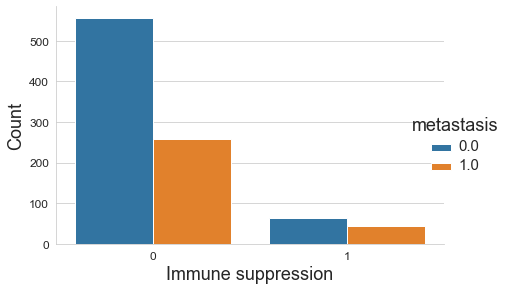

In [181]:
g= sns.catplot(data = df,  x = "immuno_suppressed", kind = "count",
                     hue = "metastasis", height = 4, aspect = 1.5)
plt.xlabel("Immune suppression", size = 18)
plt.ylabel ("Count",  size = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 15)
plt.savefig('../figures/immuno_suppression.png', bbox_inches = 'tight')


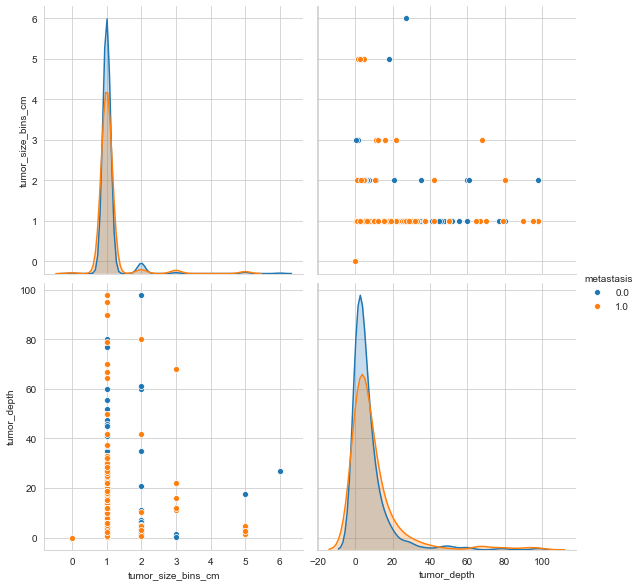

In [182]:
sns.set_style('whitegrid')
g = sns.pairplot(data = df[['tumor_size_bins_cm', 'tumor_depth', 'metastasis']],
             hue = "metastasis",  height = 4)
plt.savefig('../figures/tumor_size_vs_depth.png', bbox_inches = 'tight')
